In [16]:
# Install if needed:
# !pip install transformers torch matplotlib

import torch
from torch import nn
from transformers import BertTokenizer, BertModel
import json, math
import matplotlib.pyplot as plt


In [17]:
class BERTToRotation(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 15)  # 5 fingers × 3 classes
        )

    def forward(self, x):
        return self.linear(x).view(-1, 5, 3)  # [batch_size, 5 fingers, 3 class logits]


In [18]:
# Label encoding: 0 = Full Curl, 1 = Half Curl, 2 = No Curl
gesture_to_vector_map = {
    "thumbs_up": [2, 0, 0, 0, 0],
    "victory":   [0, 2, 2, 0, 0],
    "fist":      [0, 0, 0, 0, 0],
    "open_hand": [2, 2, 2, 2, 2],
}

def gesture_to_vector(name):
    return torch.tensor(gesture_to_vector_map.get(name, [2]*5), dtype=torch.long)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
# Load the extended dataset
from sklearn.model_selection import train_test_split

with open("training_pairs_extended.json") as f:
    samples = json.load(f)

# Split dataset into 80% train and 20% validation
train_samples, val_samples = train_test_split(samples, test_size=0.2, random_state=42)


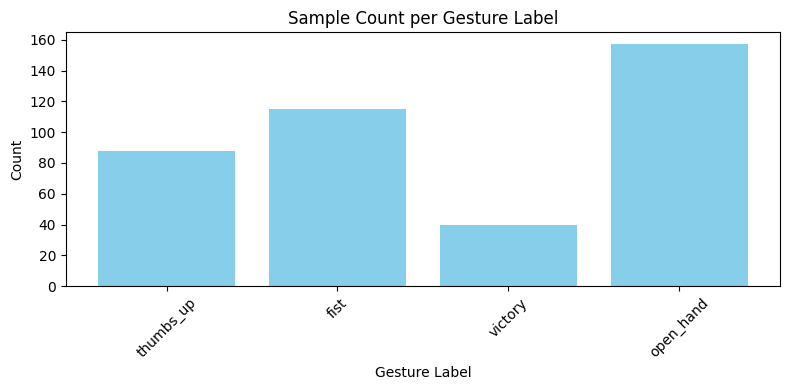

In [20]:
from collections import Counter
import pandas as pd

# Count labels
label_counts = Counter([s['label'] for s in samples])
df = pd.DataFrame(label_counts.items(), columns=["Label", "Count"])

# Plot
plt.figure(figsize=(8, 4))
plt.bar(df["Label"], df["Count"], color='skyblue')
plt.title("Sample Count per Gesture Label")
plt.xlabel("Gesture Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
model = BERTToRotation()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
train_losses = []
val_accuracies = []

for epoch in range(10):
    total_loss = 0.0

    # --- Training phase ---
    for sample in train_samples:
        text, label = sample["text"], sample["label"]
        tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)
        with torch.no_grad():
            pooled = bert(**tokens).pooler_output

        logits = model(pooled).squeeze(0)  # [5, 3]
        target = gesture_to_vector(label)  # [5]
        loss = loss_fn(logits, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_samples))

    # --- Validation phase ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample in val_samples:
            text, label = sample["text"], sample["label"]
            tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=10)
            pooled = bert(**tokens).pooler_output
            logits = model(pooled).squeeze(0)  # [5, 3]
            pred = torch.argmax(logits, dim=-1)  # [5]
            target = gesture_to_vector(label)  # [5]
            correct += (pred == target).all().item()
            total += 1
    model.train()

    accuracy = correct / total
    val_accuracies.append(accuracy)
    print(f"Epoch {epoch+1} - Loss: {train_losses[-1]:.4f} | Val Acc: {accuracy*100:.2f}%")


Epoch 1 - Loss: 0.7290 | Val Acc: 17.50%
Epoch 2 - Loss: 0.6447 | Val Acc: 31.25%
Epoch 3 - Loss: 0.6157 | Val Acc: 48.75%
Epoch 4 - Loss: 0.5858 | Val Acc: 50.00%
Epoch 5 - Loss: 0.5540 | Val Acc: 55.00%
Epoch 6 - Loss: 0.5218 | Val Acc: 63.75%
Epoch 7 - Loss: 0.4903 | Val Acc: 63.75%
Epoch 8 - Loss: 0.4605 | Val Acc: 63.75%
Epoch 9 - Loss: 0.4329 | Val Acc: 67.50%
Epoch 10 - Loss: 0.4076 | Val Acc: 71.25%


In [22]:
torch.save(model.state_dict(), "bert_to_finger_curl.pth")
print("✅ Model saved.")


✅ Model saved.


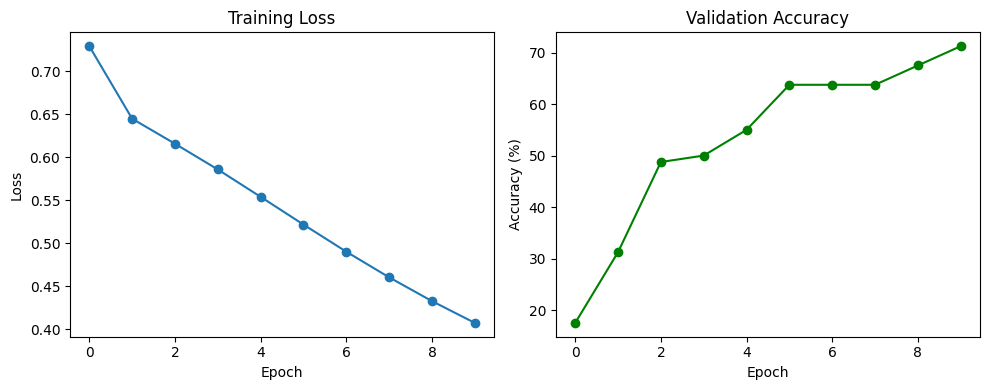

In [23]:
# Plot training loss and validation accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([v * 100 for v in val_accuracies], marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()
